# Model trained on dataset B1 

In [1]:
import torch
import skimage as ski
import numpy as np
from torch.utils.data import Dataset
import os
import pandas as pd
from torchvision.io import read_image
from torchvision import transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import time
import matplotlib.pyplot as plt
import copy

### Data loading

In [2]:
class PetDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_annotations = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_annotations)
    
    def __getitem__(self,idx):
        img_path = os.path.join(self.img_dir,self.img_annotations.iloc[idx,0])
        image = ski.io.imread(img_path)/255   
        image = image[:,:,:3] 
        class_label = self.img_annotations.iloc[idx,2]-1     
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            class_label = self.target_transform(class_label)     
        return image, class_label
    
size = 256
resize = T.Resize(size)
totensor = T.ToTensor()
trans = T.Compose([totensor,resize]) 

train = PetDataset('annotations_aug/annotations_train_B1.csv','img_augmented_processed/', transform = trans)
valid = PetDataset('annotations_aug/annotations_valid_B1.csv','img_augmented_processed/', transform = trans)
test = PetDataset('annotations_aug/annotations_test_B1.csv','img_augmented_processed/', transform = trans)

train_loader = DataLoader(train,batch_size=64,shuffle=True)
valid_loader = DataLoader(valid,batch_size=len(valid),shuffle=True)
test_loader = DataLoader(test,batch_size=len(test),shuffle=True)

shape of training batch (images): torch.Size([64, 3, 256, 256])
shape of training batch (labels): torch.Size([64])


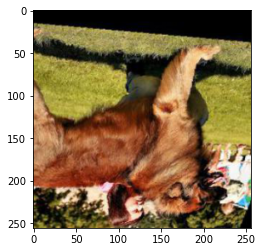

In [3]:
train_b1_img, train_b1_label = next(iter(train_loader))
print('shape of training batch (images): {}'.format(train_b1_img.shape))
print('shape of training batch (labels): {}'.format(train_b1_label.shape))
plt.imshow(train_b1_img[np.random.randint(64)].permute(1,2,0))     #plt.imshow needs the shape to be (x,y,3)
plt.show()

### Model

In [7]:
class PetCNN6(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( #nn.Dropout2d(0.1),
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( #nn.Dropout2d(0.1),
                                    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.1),
                                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.1),
                                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential( nn.Dropout(0.1),
                                    nn.Conv2d(in_channels=256, out_channels=370, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(370),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.2),
                                    nn.Linear(int(370*((size-224)/32)*((size-224)/32)), 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = out.view(out.size(0),-1)      # reshaping the output shaped (N,C,H,W) from the conv layer to (N,n_inp) for the dense layer
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    


model = PetCNN6()
loss_function = nn.NLLLoss()

#print(model)

### Helper functions

In [5]:
def model_dict(model,iteration,current_train_accuracy,current_valid_accuracy):
    """
    Returns a dictionary with a deep copy of the model in its current state and the associated accuracy metrics.
    """
    
    return {'current_model': copy.deepcopy(model), 'current_iter':copy.deepcopy(iteration), 'current_train_acc':copy.deepcopy(current_train_accuracy), 'current_valid_acc':copy.deepcopy(current_valid_accuracy)}

def add_to_saved_models(saved_models,length,model,iteration,current_train_accuracy,current_valid_accuracy):
    """
    saved_models is a list of specified length where we save the deep copies of the model at different training stages with the best validation accuracies.
    
    This function adds a dictionary created by model_dict(...) defined above either if the list of saved_models is not full yet, or if the current version of the model is better than the worst one already saved in the list.
    """
    
    dic = model_dict(model,iteration,current_train_accuracy,current_valid_accuracy)
    
    if len(saved_models)<length:
        saved_models.append(dic)
    else:
        valid_acc_list = [dictionary['current_valid_acc'] for dictionary in saved_models]
        min_valid_acc = min(valid_acc_list)
        min_valid_index = valid_acc_list.index(min_valid_acc)
        
        if dic['current_valid_acc'] > min_valid_acc:
            saved_models[min_valid_index] = dic

### Training

In [8]:
saved_models = []

learning_rate = 0.001
wt_decay = 0.0003
lr_decay = 0.75    # we'll go for a learning rate decay by a factor of 0.75 every 2 epochs

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, weight_decay=wt_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=lr_decay)

num_epochs = 40

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()


for epoch in range(num_epochs):
    for images, labels in train_loader:
        model.train()
        out = model(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%25==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 25 iterations: {}'.format(end-start))
            print('Current learning rate:{}'.format(optimizer.param_groups[0]['lr']))    # to print the current learning rate that is decaying every 2 epochs
            
            
            if epoch>0:      # after the first epoch, every 25th iteration is a checkpoint
                
                model.eval()
                with torch.no_grad():
                    train_part = DataLoader(train,batch_size=1024,shuffle=True)   # a (pseudo) random batch from the training set
                    images_c, labels_c = next(iter(train_part))
                    train_out = model(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/1024
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)
                    
                    if current_valid_accuracy > 0.53:
                        add_to_saved_models(saved_models,5,model,iteration,current_train_accuracy,current_valid_accuracy)
                        

                
            start = time.time()
            
    scheduler.step()
                


Epoch:0
Iteration:25
Time taken for the last 25 iterations: 34.58634614944458
Current learning rate:0.001
Epoch:0
Iteration:50
Time taken for the last 25 iterations: 40.80259156227112
Current learning rate:0.001
Epoch:0
Iteration:75
Time taken for the last 25 iterations: 39.77845573425293
Current learning rate:0.001
Epoch:0
Iteration:100
Time taken for the last 25 iterations: 38.40504574775696
Current learning rate:0.001
Epoch:0
Iteration:125
Time taken for the last 25 iterations: 37.661978006362915
Current learning rate:0.001
Epoch:0
Iteration:150
Time taken for the last 25 iterations: 37.65612983703613
Current learning rate:0.001
Epoch:0
Iteration:175
Time taken for the last 25 iterations: 38.38805055618286
Current learning rate:0.001
Epoch:0
Iteration:200
Time taken for the last 25 iterations: 37.36427617073059
Current learning rate:0.001
Epoch:0
Iteration:225
Time taken for the last 25 iterations: 37.69256138801575
Current learning rate:0.001
Epoch:0
Iteration:250
Time taken for th

Current validation loss:2.2752301692962646
Current validation accuracy:0.3366159498691559
Epoch:3
Iteration:925
Time taken for the last 25 iterations: 43.7707359790802
Current learning rate:0.00075
Current training loss:2.355351448059082
Current training accuracy:0.345703125
Current validation loss:2.2015771865844727
Current validation accuracy:0.36705461144447327
Epoch:3
Iteration:950
Time taken for the last 25 iterations: 42.8717782497406
Current learning rate:0.00075
Current training loss:2.179631471633911
Current training accuracy:0.361328125
Current validation loss:2.1547529697418213
Current validation accuracy:0.3625783324241638
Epoch:3
Iteration:975
Time taken for the last 25 iterations: 42.24959182739258
Current learning rate:0.00075
Current training loss:2.2226760387420654
Current training accuracy:0.380859375
Current validation loss:2.1207327842712402
Current validation accuracy:0.39480751752853394
Epoch:3
Iteration:1000
Time taken for the last 25 iterations: 43.1053116321563

Epoch:6
Iteration:1625
Time taken for the last 25 iterations: 34.876235246658325
Current learning rate:0.00042187500000000005
Current training loss:1.767923355102539
Current training accuracy:0.509765625
Current validation loss:1.8472464084625244
Current validation accuracy:0.4574753940105438
Epoch:6
Iteration:1650
Time taken for the last 25 iterations: 34.0675995349884
Current learning rate:0.00042187500000000005
Current training loss:1.6692639589309692
Current training accuracy:0.5517578125
Current validation loss:1.836164116859436
Current validation accuracy:0.46911370754241943
Epoch:6
Iteration:1675
Time taken for the last 25 iterations: 32.39789128303528
Current learning rate:0.00042187500000000005
Current training loss:1.669097661972046
Current training accuracy:0.5517578125
Current validation loss:1.8239353895187378
Current validation accuracy:0.4637421667575836
Epoch:6
Iteration:1700
Time taken for the last 25 iterations: 33.32959580421448
Current learning rate:0.00042187500000

Epoch:8
Iteration:2325
Time taken for the last 25 iterations: 31.78039288520813
Current learning rate:0.00031640625000000006
Current training loss:1.3467926979064941
Current training accuracy:0.65234375
Current validation loss:1.7675071954727173
Current validation accuracy:0.5040286779403687
Epoch:9
Iteration:2350
Time taken for the last 25 iterations: 29.61462664604187
Current learning rate:0.00031640625000000006
Current training loss:1.5482256412506104
Current training accuracy:0.6044921875
Current validation loss:1.9071271419525146
Current validation accuracy:0.4547896087169647
Epoch:9
Iteration:2375
Time taken for the last 25 iterations: 30.359354257583618
Current learning rate:0.00031640625000000006
Current training loss:1.432063341140747
Current training accuracy:0.609375
Current validation loss:1.83102548122406
Current validation accuracy:0.46911370754241943
Epoch:9
Iteration:2400
Time taken for the last 25 iterations: 31.155521631240845
Current learning rate:0.00031640625000000

Epoch:11
Iteration:3025
Time taken for the last 25 iterations: 30.282963752746582
Current learning rate:0.00023730468750000005
Current training loss:0.8723641633987427
Current training accuracy:0.8037109375
Current validation loss:1.6628793478012085
Current validation accuracy:0.5201432704925537
Epoch:11
Iteration:3050
Time taken for the last 25 iterations: 29.53693699836731
Current learning rate:0.00023730468750000005
Current training loss:0.9162188768386841
Current training accuracy:0.794921875
Current validation loss:1.628641963005066
Current validation accuracy:0.522828996181488
Epoch:11
Iteration:3075
Time taken for the last 25 iterations: 29.285810708999634
Current learning rate:0.00023730468750000005
Current training loss:0.8980535268783569
Current training accuracy:0.8154296875
Current validation loss:1.626054048538208
Current validation accuracy:0.5237242579460144
Epoch:11
Iteration:3100
Time taken for the last 25 iterations: 30.80979585647583
Current learning rate:0.000237304

Epoch:14
Iteration:3725
Time taken for the last 25 iterations: 32.39019703865051
Current learning rate:0.00013348388671875002
Current training loss:0.703490674495697
Current training accuracy:0.8564453125
Current validation loss:1.6277399063110352
Current validation accuracy:0.5362578630447388
Epoch:14
Iteration:3750
Time taken for the last 25 iterations: 29.94245934486389
Current learning rate:0.00013348388671875002
Current training loss:0.781546413898468
Current training accuracy:0.8359375
Current validation loss:1.6340709924697876
Current validation accuracy:0.5273053050041199
Epoch:14
Iteration:3775
Time taken for the last 25 iterations: 30.47016668319702
Current learning rate:0.00013348388671875002
Current training loss:0.6970469951629639
Current training accuracy:0.8505859375
Current validation loss:1.6001255512237549
Current validation accuracy:0.5407341122627258
Epoch:14
Iteration:3800
Time taken for the last 25 iterations: 26.380295991897583
Current learning rate:0.00013348388

Epoch:16
Iteration:4425
Time taken for the last 25 iterations: 33.944758892059326
Current learning rate:0.00010011291503906251
Current training loss:0.5439015030860901
Current training accuracy:0.9091796875
Current validation loss:1.6199759244918823
Current validation accuracy:0.534467339515686
Epoch:17
Iteration:4450
Time taken for the last 25 iterations: 30.76287055015564
Current learning rate:0.00010011291503906251
Current training loss:0.5448325276374817
Current training accuracy:0.9140625
Current validation loss:1.629812479019165
Current validation accuracy:0.5434198975563049
Epoch:17
Iteration:4475
Time taken for the last 25 iterations: 31.97586989402771
Current learning rate:0.00010011291503906251
Current training loss:0.539215624332428
Current training accuracy:0.9111328125
Current validation loss:1.613887906074524
Current validation accuracy:0.5317815542221069
Epoch:17
Iteration:4500
Time taken for the last 25 iterations: 32.22412633895874
Current learning rate:0.0001001129150

Epoch:19
Iteration:5125
Time taken for the last 25 iterations: 33.760263442993164
Current learning rate:7.508468627929689e-05
Current training loss:0.46387383341789246
Current training accuracy:0.9287109375
Current validation loss:1.608805775642395
Current validation accuracy:0.5434198975563049
Epoch:19
Iteration:5150
Time taken for the last 25 iterations: 35.63734841346741
Current learning rate:7.508468627929689e-05
Current training loss:0.5082120299339294
Current training accuracy:0.91796875
Current validation loss:1.6075265407562256
Current validation accuracy:0.5407341122627258
Epoch:19
Iteration:5175
Time taken for the last 25 iterations: 33.638779401779175
Current learning rate:7.508468627929689e-05
Current training loss:0.46542394161224365
Current training accuracy:0.9365234375
Current validation loss:1.614691972732544
Current validation accuracy:0.5407341122627258
Epoch:19
Iteration:5200
Time taken for the last 25 iterations: 34.222416639328
Current learning rate:7.508468627929

Epoch:22
Iteration:5825
Time taken for the last 25 iterations: 34.10936212539673
Current learning rate:4.22351360321045e-05
Current training loss:0.4435836374759674
Current training accuracy:0.9384765625
Current validation loss:1.6152151823043823
Current validation accuracy:0.5505819320678711
Epoch:22
Iteration:5850
Time taken for the last 25 iterations: 33.93255662918091
Current learning rate:4.22351360321045e-05
Current training loss:0.44489720463752747
Current training accuracy:0.94140625
Current validation loss:1.6228290796279907
Current validation accuracy:0.5407341122627258
Epoch:22
Iteration:5875
Time taken for the last 25 iterations: 32.308438539505005
Current learning rate:4.22351360321045e-05
Current training loss:0.406328022480011
Current training accuracy:0.939453125
Current validation loss:1.6170783042907715
Current validation accuracy:0.5434198975563049
Epoch:22
Iteration:5900
Time taken for the last 25 iterations: 34.1446967124939
Current learning rate:4.22351360321045e-

Epoch:24
Iteration:6525
Time taken for the last 25 iterations: 32.35902404785156
Current learning rate:3.167635202407837e-05
Current training loss:0.36983856558799744
Current training accuracy:0.9541015625
Current validation loss:1.6477891206741333
Current validation accuracy:0.5452103614807129
Epoch:25
Iteration:6550
Time taken for the last 25 iterations: 34.18218994140625
Current learning rate:3.167635202407837e-05
Current training loss:0.4027291238307953
Current training accuracy:0.9443359375
Current validation loss:1.65606689453125
Current validation accuracy:0.5416293740272522
Epoch:25
Iteration:6575
Time taken for the last 25 iterations: 33.33825087547302
Current learning rate:3.167635202407837e-05
Current training loss:0.4192725121974945
Current training accuracy:0.947265625
Current validation loss:1.6450037956237793
Current validation accuracy:0.5380483269691467
Epoch:25
Iteration:6600
Time taken for the last 25 iterations: 33.38361883163452
Current learning rate:3.167635202407

Epoch:27
Iteration:7225
Time taken for the last 25 iterations: 33.74906587600708
Current learning rate:2.3757264018058778e-05
Current training loss:0.419124037027359
Current training accuracy:0.94140625
Current validation loss:1.6326788663864136
Current validation accuracy:0.5496866703033447
Epoch:27
Iteration:7250
Time taken for the last 25 iterations: 33.98708200454712
Current learning rate:2.3757264018058778e-05
Current training loss:0.37364521622657776
Current training accuracy:0.9462890625
Current validation loss:1.6321337223052979
Current validation accuracy:0.547896146774292
Epoch:27
Iteration:7275
Time taken for the last 25 iterations: 33.71887564659119
Current learning rate:2.3757264018058778e-05
Current training loss:0.3673485517501831
Current training accuracy:0.955078125
Current validation loss:1.6360951662063599
Current validation accuracy:0.5434198975563049
Epoch:27
Iteration:7300
Time taken for the last 25 iterations: 33.78690576553345
Current learning rate:2.37572640180

Epoch:30
Iteration:7925
Time taken for the last 25 iterations: 33.51026463508606
Current learning rate:1.3363461010158061e-05
Current training loss:0.35073333978652954
Current training accuracy:0.9482421875
Current validation loss:1.636022686958313
Current validation accuracy:0.5434198975563049
Epoch:30
Iteration:7950
Time taken for the last 25 iterations: 35.16513228416443
Current learning rate:1.3363461010158061e-05
Current training loss:0.37676262855529785
Current training accuracy:0.9482421875
Current validation loss:1.6387484073638916
Current validation accuracy:0.5514771938323975
Epoch:30
Iteration:7975
Time taken for the last 25 iterations: 34.86659073829651
Current learning rate:1.3363461010158061e-05
Current training loss:0.3840125799179077
Current training accuracy:0.953125
Current validation loss:1.6440675258636475
Current validation accuracy:0.547896146774292
Epoch:30
Iteration:8000
Time taken for the last 25 iterations: 34.50062322616577
Current learning rate:1.33634610101

Epoch:33
Iteration:8625
Time taken for the last 25 iterations: 34.766178369522095
Current learning rate:1.0022595757618546e-05
Current training loss:0.36833569407463074
Current training accuracy:0.955078125
Current validation loss:1.6409664154052734
Current validation accuracy:0.5434198975563049
Epoch:33
Iteration:8650
Time taken for the last 25 iterations: 36.583558559417725
Current learning rate:1.0022595757618546e-05
Current training loss:0.3602297306060791
Current training accuracy:0.947265625
Current validation loss:1.6481150388717651
Current validation accuracy:0.5452103614807129
Epoch:33
Iteration:8675
Time taken for the last 25 iterations: 34.7071008682251
Current learning rate:1.0022595757618546e-05
Current training loss:0.35325559973716736
Current training accuracy:0.9541015625
Current validation loss:1.6397159099578857
Current validation accuracy:0.5550581812858582
Epoch:33
Iteration:8700
Time taken for the last 25 iterations: 23.046222448349
Current learning rate:1.00225957

KeyboardInterrupt: 

### Learning curves

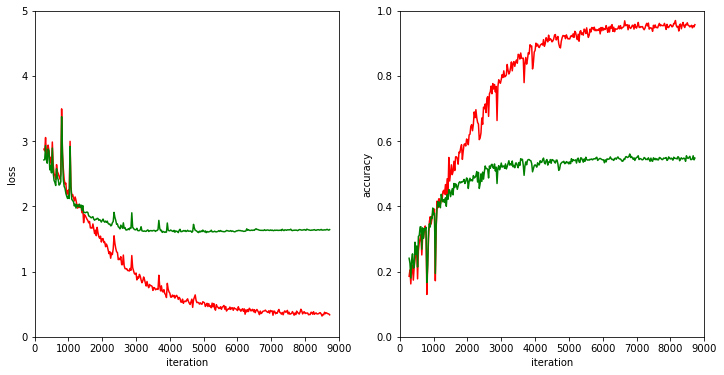

In [9]:
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,9000)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,9000)
acc_graph.set_ylim(0,1)

plt.show() 

### Saving the top 5 models

In [10]:
saved_models

[{'current_model': PetCNN6(
    (conv1): Sequential(
      (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
      (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
    )
    (conv2): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
      (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
    )
    (conv3): Sequential(
      (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
    )
    (conv4): Sequential(
      (0): Dropout2d(p=0.1, inplace=False)
      (1): Conv2d(64, 128, kernel_size=(3, 3), 

In [11]:
def save_model(n):
    """
    n is the index of the model in the list saved_models. We'll have filenames that tell you the epoch, for example, B2_3675.pt
    """
    
    torch.save(saved_models[n]['current_model'].state_dict(),'models/B1/B1_' + str(saved_models[n]['current_iter']) + '.pt')

In [12]:
for n in range(5):
    save_model(n)

In [13]:
modelt = PetCNN6()                        
model.load_state_dict(torch.load('models/B1/B1_6800.pt'))
model.eval()

valid_e = next(iter(valid_loader))
valid_o = model(valid_e[0].float())
valid_loss = loss_function(valid_o,valid_e[1])
valid_accuracy = (torch.max(valid_o,1)[1]==valid_e[1]).sum()/len(valid)

print('validation loss:{}'.format(valid_loss))
print('validation accuracy:{}'.format(valid_accuracy))

validation loss:1.641662836074829
validation accuracy:0.5604297518730164
